In [1]:
import numpy as np
import matplotlib.pyplot as plt
from architecture.Model import Model
from dataloader.Dataloader import *
from train.Trainer import *
import torch
from munch import Munch
from evaluation.Evaluator import Evaluator
from torchvision.utils import make_grid

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/balt/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [2]:
#argparser doesnt work for jupyter notebook
model_params = Munch({
    'img_size': 256, #256
    'latent_dim': 16,
    'style_dim': 64,
    'num_domains' : 2, #celeba
    'fan_pretrained_fname' : "architecture/FAN/weights.pth",
    "wFilter" : 1 # 0<= -> no FAN
})

In [3]:
#load trained networks
nets, _ = Model(model_params) #instantiate model
cpt = torch.load("runs/with_FAN/000005__networks_copy.cpt") #take the copy weights -> moving average improves quality

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model_name, model in nets.items():
    print(model_name)
    if model_name in cpt:
        model.load_state_dict(cpt[model_name])
        model.eval().to(device)

generator
mapping_network
style_encoder
discriminator
fan


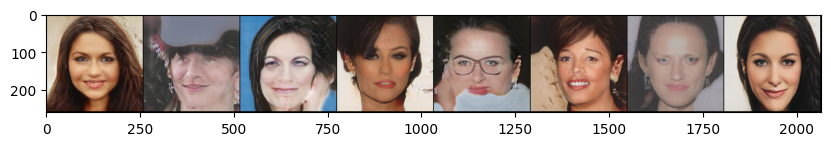

In [5]:
#test if weight upload worked correctly
root = "../shared/stargan_folder/data/celeba_hq/train" #if gpu server

train_loader = get_loader(root, 8, model_params.img_size)


train_fetcher=Fetcher(train_loader)
inputs = next(train_fetcher)
x_org,y_org = inputs.x, inputs.y
z1, z2 = inputs.z1, inputs.z2
x_ref1, x_ref2 = inputs.x_ref1, inputs.x_ref2
y_trg = inputs.y_trg

generator = nets.generator
mn = nets.mapping_network

style = mn(z1,y_trg)
input_img=x_org
masks = nets.fan.get_heatmap(input_img) if model_params.wFilter>0 else None
x_fake=generator(input_img,style,masks)

x_n = [(x-x.min())/(x.max()-x.min()) for x in x_fake]
#normalize_tensor(x_fake)

grid = make_grid(x_n)



imgs=torch.permute(grid, [1,2,0]).cpu().detach().numpy()
#save_image(grid,"test.png")


#fake_img=torch.permute((x_fake+1)/2, [1,2,0]).cpu().detach().numpy()

plt.figure(figsize=(10,5))
plt.imshow(imgs)
plt.show()

In [14]:
#argparser doesnt work for jupyter notebook
eval_params = Munch({
    'img_size': 256, #256
    'latent_dim': 16,
    'batch_size': 16,
    'num_outputs' : 10,
    "wFilter" : 1, # 0<= -> no FAN
    "val_dir" : "../shared/stargan_folder/data/celeba_hq/val",
    "save_dir" : "eval"
})

In [7]:
evaluator = Evaluator(eval_params, nets, eval_params.val_dir)

In [8]:
evaluator.evaluate_lpips(mode="latent")

male to female generation
female to male generation


{'male2female': tensor(0.4716, device='cuda:0'),
 'female2male': tensor(0.5184, device='cuda:0'),
 'LPIPS_latent/mean': tensor(0.4950, device='cuda:0')}

In [11]:
import shutil

In [17]:
task = "dog2wild"
path_fake = os.path.join(eval_params.save_dir, task)
#create directory to store task specific outputs (used for FID)
#delete pre-existing folder
shutil.rmtree(path_fake, ignore_errors=True) #removes folder and its content
#create folder
os.makedirs(path_fake) #makedirs creates the intermediate folders (not mkdir)
